<a href="https://colab.research.google.com/github/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/blob/heterogen-classification-firstModel/Diplomska_naloga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
# @title Download whl-s and requirements
import urllib.request
import sys

urllib.request.urlretrieve("https://raw.githubusercontent.com/JasaZnidar/Predvidenje-zmagovalca-vaterpolo/refs/heads/main/requirements.txt", "requirements.txt")

('requirements.txt', <http.client.HTTPMessage at 0x784e25ce6250>)

In [ ]:
# @title pip
!sudo apt-get install libcairo2-dev pkg-config python3-dev
!pip install --upgrade pip
!pip install --force-reinstall --no-cache-dir pycairo

!pip install -r requirements.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libffi-dev libglib2.0-dev
  libglib2.0-dev-bin libice-dev liblzo2-2 libmount-dev libpixman-1-dev
  libselinux1-dev libsepol-dev libsm-dev libxcb-render0-dev libxcb-shm0-dev
Suggested packages:
  libcairo2-doc libgirepository1.0-dev libglib2.0-doc libgdk-pixbuf2.0-bin
  | libgdk-pixbuf2.0-dev libxml2-utils libice-doc libsm-doc
The following packages will be REMOVED:
  pkgconf r-base-dev
The following NEW packages will be installed:
  libblkid-dev libcairo-script-interpreter2 libcairo2-dev libffi-dev
  libglib2.0-dev libglib2.0-dev-bin li

In [ ]:
# @title Imports
import json
import copy
import networkx as nx
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.utils.convert import from_networkx
from torch_geometric import nn, sampler
from torch_geometric.data import HeteroData, Data
from torch_geometric import transforms as T
from torch_geometric import loader
from torcheval import metrics as M
from torcheval.metrics import R2Score, MeanSquaredError
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import requests
from zipfile import ZipFile
from math import log
from io import BytesIO
import warnings
import numpy as np
%matplotlib inline

# Data Setup

In [ ]:
# @title Data settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'

win_value = 1.0
loss_value = -1.0
tie_value = (win_value + loss_value)/2
tie_accuracy = 0.1

data_file = "test"
train_rate = 0.7
val_rate = 1.0 - train_rate

# goals, shots, assists, blocks, saves, exclusion, penalty foul, suspention, brutality, sprint won, sprints
used_features = [1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
num_playerInMatch_features = sum(used_features)
# birth, hand height, position, weight
used_player_stats = [1, 1, 1, 1, 1]
num_player_features = sum(used_player_stats)

In [ ]:
# @title Get JSON data from github
with requests.get(f"https://github.com/JasaZnidar/totalwaterpolo-web-scraper/raw/master/{data_file}.zip", ) as r:
  ZipFile(BytesIO(r.content), "r").extractall()

In [ ]:
# @title Extract data to json object
with open(f"/content/{data_file}.json") as f:
    scraped_data = json.load(f)

## Supporting functions

In [ ]:
# @title Filter features
def filterFeatures(features: list[float]) -> list[float]:
  assert len(features) == len(used_features)

  return [features[i] for i in range(len(features)) if used_features[i]]

In [ ]:
# @title Event data to vector data
def eventToVector(event: dict) -> tuple[list[float], list[float]]:
  global used_features

  player1Statistic = [0.0]*len(used_features)
  player2Statistic = [0.0]*len(used_features)

  if "goal scored" in event['action']:
    # goals
    player1Statistic[0] += 1
    # shots
    player1Statistic[1] += 1
    # assists
    player2Statistic[2] += 1

  elif "exclusion" in event['action']:
    # exclusion
    player1Statistic[5] += 1

  elif "penalty foul" in event['action']:
    # penalty
    player1Statistic[6] += 1

  elif "shot missed" in event['action']:
    # shots
    player1Statistic[1] += 1

  elif "shot saved" in event['action']:
    # shots
    player1Statistic[1] += 1
    # saves
    player2Statistic[4] += 1

  elif "shot blocked" in event['action']:
    # shots
    player1Statistic[1] += 1
    # blocks
    player2Statistic[3] += 1

  elif "suspention" in event['action']:
    # suspensions
    player1Statistic[7] += 1

  elif "brutality" in event['action']:
    # brutalities
    player1Statistic[8] += 1

  elif "sprint won" in event['action']:
    # sprint won
    player1Statistic[9] += 1
    # sprint
    player1Statistic[10] += 1
    # sprint
    player2Statistic[10] += 1

  player1Statistic = filterFeatures(player1Statistic)
  player2Statistic = filterFeatures(player2Statistic)

  return (player1Statistic, player2Statistic);

In [ ]:
# @title Result classification
def resultClass(result: float) -> float:
  if result > tie_value + win_value*tie_accuracy:
    return win_value
  elif result < tie_value + loss_value*tie_accuracy:
    return loss_value
  else:
    return tie_value

In [ ]:
# @title Is second player ally
def isAlly(event: dict) -> bool:
  if 'goal scored' in event['action']:
    return True
  return False

In [ ]:
# @title Update list
def Update(original: list, update: list) -> list:
  assert len(original) == len(update)

  return[original[x] + update[x] for x in range(len(original))]

In [ ]:
# @title Gather match ids
match_ids = [match_id for match_id in scraped_data['matches']]

## Data generation

In [ ]:
# @title Player data gathering
player_data = {}
player_ids = [player_id for player_id in scraped_data['players']]

for player_id in player_ids:
  # birth, hand, height, position, weight
  player_data[player_id] = [0.0]*5

  player_data[player_id][0] = scraped_data['players'][player_id]['birth']
  player_data[player_id][1] = 1 if scraped_data['players'][player_id]['hand'] == 'R' else -1 if scraped_data['players'][player_id]['hand'] == 'L' else 0
  player_data[player_id][2] = scraped_data['players'][player_id]['height'] if scraped_data['players'][player_id]['height'] else 0
  player_data[player_id][4] = scraped_data['players'][player_id]['weight'] if scraped_data['players'][player_id]['weight'] else 0
  match scraped_data['players'][player_id]['position']:
      case '':
        player_data[player_id][3] = 0
      case 'Goalkeeper':
        player_data[player_id][3] = 1
      case 'Driver':
        player_data[player_id][3] = 2
      case 'Left Driver':
        player_data[player_id][3] = 3
      case 'Right Driver':
        player_data[player_id][3] = 4
      case 'Central Defender':
        player_data[player_id][3] = 5
      case 'Left Winger':
        player_data[player_id][3] = 6
      case 'Right Winger':
        player_data[player_id][3] = 7
      case 'Center Forward':
        player_data[player_id][3] = 8

In [ ]:
# @title Team data gathering
match_list = match_ids
results = {}
team_data = {}

match_data = {}  # match_id: ['team A', [...], {...}, 'team B', [...], {...}, 4] home team name, home player lineups(the index dictates the players hat number), home statistics, away team name, away player lineups(the index dictates the players hat number), away statistics, result diff

for match_id in match_list:
  #=============================================================================
  # Collect match data
  #=============================================================================
  lineups = scraped_data['matches'][match_id]['lineup']
  match_data[match_id] = [
      scraped_data['matches'][match_id]['name']['home'],
      [lineups['home'][str(i + 1)]['id'] if str(i + 1) in lineups['home'] else 0 for i in range(15)],
      {},
      scraped_data['matches'][match_id]['name']['away'],
      [lineups['away'][str(i + 1)]['id'] if str(i + 1) in lineups['away'] else 0 for i in range(15)],
      {},
      abs(scraped_data['matches'][match_id]['result']['home'] - scraped_data['matches'][match_id]['result']['away'])
  ]
  """results[match_id] = scraped_data['matches'][match_id]['result']['home'] - scraped_data['matches'][match_id]['result']['away']
  if results[match_id] == 0:
    del results[match_id]
    continue"""

  #=============================================================================
  # Prepare statistics dictionary for a teams players
  #=============================================================================
  statistics = {
      'home': {int(x): [0.0]*sum(used_features) for x in scraped_data['matches'][match_id]['lineup']['home']},
      'away': {int(x): [0.0]*sum(used_features) for x in scraped_data['matches'][match_id]['lineup']['away']}
  }

  if len(statistics['home']) < 7 or len(statistics['away']) < 7:
    #del results[match_id]
    del match_data[match_id]
    continue

  #=============================================================================
  # Add missing teams in team_data
  #=============================================================================
  """for team in ['home', 'away']:
    if not scraped_data['matches'][match_id]['name'][team] in team_data:
      team_data[scraped_data['matches'][match_id]['name'][team]] = [[0.0]*11, 0]"""

  #=============================================================================
  # Loop through all events and update player statistics
  #=============================================================================
  for event in scraped_data['matches'][match_id]['plays']:
    num_1 = event['player_1']
    num_2 = event['player_2']
    primary_team = event['team']
    secondary_team = primary_team if isAlly(event) else 'away' if primary_team == 'home' else 'home'

    # no player was recorded for this event
    if num_1 == 0:
      continue

    # no secondary player was recorded for this event
    elif num_2 == 0:
      data_1, _ = eventToVector(event)
      statistics[primary_team][num_1] = Update(statistics[primary_team][num_1], data_1)

    # there are 2 players recorded for this event
    else:
      data_1, data_2 = eventToVector(event)
      statistics[primary_team][num_1] = Update(statistics[primary_team][num_1], data_1)
      statistics[secondary_team][num_2] = Update(statistics[secondary_team][num_2], data_2)

  #=============================================================================
  # Save team statistics
  #=============================================================================
  match_data[match_id][2] = statistics['home']
  match_data[match_id][5] = statistics['away']

In [ ]:
# @title Function to create HeteroData
def createData(match_data: dict[str, list], N: int = -1):
  global player_data

  #=============================================================================
  # skip last N matches
  #=============================================================================
  if N > 0:
    match_ids = [int(id) for id in match_data.keys()]
    match_ids.sort()
    match_ids = match_ids[:-N]

    new_match_data = {str(id): match_data[str(id)] for id in match_ids}
    match_data = new_match_data

  #=============================================================================
  # Create player matrix
  #=============================================================================
  players_list = set()
  teams_list = set()
  for match_id in match_data:
    teams_list.add(match_data[match_id][0])
    teams_list.add(match_data[match_id][3])
    for home_player in match_data[match_id][1]:
      players_list.add(int(home_player))
    for away_player in match_data[match_id][4]:
      players_list.add(int(home_player))

  teams_list = list(teams_list)
  players_list = list(players_list)

  player_matrix = torch.zeros((len(players_list), sum(used_player_stats)), dtype=torch.float32)
  playerId_to_index = {str(players_list[i]): i for i in range(len(players_list))}

  for player_id in player_data:
    if player_id not in playerId_to_index:
      continue

    cnt = 0
    for stat in used_player_stats:
      if stat:
        player_matrix[playerId_to_index[player_id], cnt] = player_data[player_id][cnt]
      cnt += 1

  #=============================================================================
  # Create playerInMatch and edge matricies
  #=============================================================================
  # set starting player in match values and connect them to their games
  playerInMatch_matrix = torch.zeros((len(players_list), sum(used_features)), dtype=torch.float32)
  playerInMatch_player_matrix = torch.Tensor([[x for x in range(len(players_list))]]*2).T.long()   # playerInMatch -> player

  # set starting team values
  team_nameToIndex = {teams_list[i]: i for i in range(len(teams_list))}
  teamInMatch_num = 0
  teamInMatch_team_matrix = torch.zeros((0, 2), dtype=torch.long)  # teamInMatch -> team
  teamInMatch_playerInMatch_matrix = torch.zeros((0, 2), dtype=torch.long)   # teamInMatch -> playerInMatch
  teamInMatch_playerInMatch_attr = torch.zeros((1, 0), dtype=torch.float32)
  teamInMatch_teamInMatch_matrix = torch.zeros((0, 2), dtype=torch.long)   # teamInMatch -> teamInMatch
  teamInMatch_teamInMatch_result = torch.zeros((0, ), dtype=torch.float32)
  teamInMatch_teamInMatch_weight = torch.zeros((0,), dtype=torch.float32)

  # sort match
  match_list.sort(key=lambda x: int(x))

  #=============================================================================
  # Fill up playerInMatch matrix and edges
  #=============================================================================
  # loop through matches and update data in playerInMatch matrix
  for match_id in match_list:
    if match_id not in match_data:
      continue

    # add teamInMatch
    teamInMatch_num += 2

    # link teamInMatch to team
    teamInMatch_team_matrix = torch.cat((teamInMatch_team_matrix, torch.Tensor([[teamInMatch_num - 2, team_nameToIndex[match_data[match_id][0]]]])), dim=0)  # home
    teamInMatch_team_matrix = torch.cat((teamInMatch_team_matrix, torch.Tensor([[teamInMatch_num - 1, team_nameToIndex[match_data[match_id][3]]]])), dim=0)  # away

    # link teamInMatch to teamInMatch
    # home
    teamInMatch_teamInMatch_matrix = torch.cat((teamInMatch_teamInMatch_matrix, torch.Tensor([[teamInMatch_num - 2, teamInMatch_num - 1]])), dim=0)
    teamInMatch_teamInMatch_result = torch.cat((teamInMatch_teamInMatch_result, torch.Tensor([1.0 if match_data[match_id][6] > 0 else -1.0 if match_data[match_id][6] < 0 else 0.0])))
    teamInMatch_teamInMatch_weight = torch.cat((teamInMatch_teamInMatch_weight, torch.Tensor([match_data[match_id][6]])))
    # away
    teamInMatch_teamInMatch_matrix = torch.cat((teamInMatch_teamInMatch_matrix, torch.Tensor([[teamInMatch_num - 1, teamInMatch_num - 2]])), dim=0)
    teamInMatch_teamInMatch_result = torch.cat((teamInMatch_teamInMatch_result, torch.Tensor([-1.0 if match_data[match_id][6] > 0 else 1.0 if match_data[match_id][6] < 0 else 0.0])))
    teamInMatch_teamInMatch_weight = torch.cat((teamInMatch_teamInMatch_weight, torch.Tensor([match_data[match_id][6]])))

    # team_data => (match_data index for lineup, teamInMatch_matrix index for team)
    for team_data in [(1, -2), (4, -1)]:
      data_index = team_data[0]
      teamInMatch_index = team_data[1]
      for player_num in range(len(match_data[match_id][data_index])):
        player_id = match_data[match_id][data_index][player_num]
        if player_id == 0:
          continue

        # player id as an index
        if player_id in playerId_to_index:
          id = playerId_to_index[player_id]
        else:
          # player id needs to be added
          player_matrix = torch.cat((player_matrix, torch.zeros((1, sum(used_player_stats)), dtype=torch.float32)), dim=0)
          playerId_to_index[player_id] = player_matrix.shape[0]

        # find last instance of player connection in order to find latest data in playerInMatch_matrix
        last_playerInMatch_index = (playerInMatch_player_matrix[:, 0] == id).nonzero(as_tuple=False)[0][-1].item()
        updated_playerInMatch_data = torch.Tensor(Update(playerInMatch_matrix[last_playerInMatch_index, :].tolist(), match_data[match_id][data_index + 1][player_num+1])).reshape((1, -1))

        # add new data to matrix
        playerInMatch_matrix = torch.cat((playerInMatch_matrix, updated_playerInMatch_data), dim=0)

        # link playerInMatch to player
        playerInMatch_player_matrix = torch.cat((playerInMatch_player_matrix, torch.Tensor([[playerInMatch_matrix.shape[0] - 1, id]])), dim=0)

        # link teamInMatch to playerInMatch
        teamInMatch_playerInMatch_matrix = torch.cat((teamInMatch_playerInMatch_matrix, torch.Tensor([[teamInMatch_num + teamInMatch_index, playerInMatch_matrix.shape[0] - 1]])), dim=0)

        # add attribute (0 - player, 1 - goalkeeper)
        teamInMatch_playerInMatch_attr = torch.cat((teamInMatch_playerInMatch_attr, torch.Tensor([[1.0 if player_num in [1, 13] else 0]])), dim=1)

  #=============================================================================
  # Normalize matricies
  #=============================================================================
  playerInMatch_matrix = F.normalize(playerInMatch_matrix, dim=1)
  player_matrix = F.normalize(player_matrix, dim=1)
  teamInMatch_teamInMatch_weight = F.normalize(teamInMatch_teamInMatch_weight, dim=0)

  #=============================================================================
  # Create HeteroData with the created matricies
  #=============================================================================
  data = HeteroData()

  data['player'].x = player_matrix
  data['playerInMatch'].x = playerInMatch_matrix
  data['teamInMatch'].x = torch.zeros((teamInMatch_num, 0), dtype=torch.float32)
  data['team'].x = torch.zeros((len(teams_list), 0), dtype=torch.float32)

  data['playerInMatch', 'playerInstance', 'player'].edge_index = playerInMatch_player_matrix.T.type(torch.long)
  data['player', 'playerInstance', 'playerInMatch'].edge_index = torch.flip(playerInMatch_player_matrix, dims=[1]).T.type(torch.long)

  data['teamInMatch', 'played', 'playerInMatch'].edge_index = teamInMatch_playerInMatch_matrix.T.type(torch.long)
  data['teamInMatch', 'played', 'playerInMatch'].edge_attr = teamInMatch_playerInMatch_attr
  data['playerInMatch', 'played', 'teamInMatch'].edge_index = torch.flip(teamInMatch_playerInMatch_matrix, dims=[1]).T.type(torch.long)
  data['playerInMatch', 'played', 'teamInMatch'].edge_attr = teamInMatch_playerInMatch_attr

  data['teamInMatch', 'teamInstance', 'team'].edge_index = teamInMatch_team_matrix.T.type(torch.long)
  data['team', 'teamInstance', 'teamInMatch'].edge_index = torch.flip(teamInMatch_team_matrix, dims=[1]).T.type(torch.long)

  data['teamInMatch', 'result', 'teamInMatch'].edge_index = teamInMatch_teamInMatch_matrix.T.type(torch.long)
  data['teamInMatch', 'result', 'teamInMatch'].result = teamInMatch_teamInMatch_result
  data['teamInMatch', 'result', 'teamInMatch'].edge_weight = teamInMatch_teamInMatch_weight

  return data

# Learning

In [ ]:
# @title Settings
num_epoch = 100

lr = 0.02
dropout_p = 0.1
crit = torch.nn.MSELoss()
acc = M.R2Score()

In [ ]:
# @title Data
N = 10
train_data = createData(match_data, N)
test_data = createData(match_data)

In [ ]:
# @title Model
class model(torch.nn.Module):
  def __init__(self, channels: list[int], device: str='cpu', dropout: float=0.0):
    super().__init__()

    self.dropout = dropout

    self.gcn = torch.nn.ModuleList().to(device)
    for i in range(len(channels)):
      self.gcn.append(nn.HeteroConv({
        ('playerInMatch', 'playerInstance', 'player'): nn.SAGEConv((-1, -1), channels[i], add_self_loops=False),
        ('player', 'playerInstance', 'playerInMatch'): nn.SAGEConv((-1, -1), channels[i], add_self_loops=False),
        ('teamInMatch', 'played', 'playerInMatch'): nn.SAGEConv((-1, -1), channels[i], add_self_loops=False), # use GAT in order to consider players and goalkeepers diferently
        ('playerInMatch', 'played', 'teamInMatch'): nn.SAGEConv((-1, -1), channels[i], add_self_loops=False), # use GAT in order to consider players and goalkeepers diferently
        ('teamInMatch', 'teamInstance', 'team'): nn.SAGEConv((-1, -1), channels[i], add_self_loops=False),
        ('team', 'teamInstance', 'teamInMatch'): nn.SAGEConv((-1, -1), channels[i], add_self_loops=False),
        ('teamInMatch', 'result', 'teamInMatch'): nn.GraphConv((-1, -1), channels[i], add_self_loops=False),  # GraphConv uses weight
      }))

    self.lin = torch.nn.Linear(channels[-1]*2, 1)

  def forward(self, x_dict: torch.Tensor, edge_index_dict: torch.Tensor, edge_attr_dict: torch.Tensor, edge_weight_dict: torch.Tensor) -> torch.Tensor:
    # calculate values for each team
    for module in self.gcn:
      # Forward
      x_dict = module(x_dict, edge_index_dict, edge_weight_dict=edge_weight_dict)#, edge_attr_dict=edge_attr_dict, edge_weight_dict=edge_weight_dict)
      for node in x_dict:
        x_dict[node] = F.dropout(x_dict[node], p=self.dropout, training=self.training)
        if x_dict[node].isnan().any() or x_dict[node].isinf().any():
          raise Exception("{} has NaN or Inf value after Forward function.".format(node))

      # ReLu
      x_dict = {node: x.relu() for node, x in x_dict.items()}
      for node in x_dict:
        x_dict[node] = F.dropout(x_dict[node], p=self.dropout, training=self.training)
        if x_dict[node].isnan().any() or x_dict[node].isinf().any():
          raise Exception("{} has NaN or Inf value after ReLu.".format(node))

      # Normalize
      for node in x_dict:
        x_dict[node] = F.normalize(x_dict[node], dim=1)
      for node in x_dict:
        x_dict[node] = F.dropout(x_dict[node], p=self.dropout, training=self.training)
        if x_dict[node].isnan().any() or x_dict[node].isinf().any():
          raise Exception("{} has NaN or Inf value.".format(node))

    # get for match result
    x = x_dict['teamInMatch']
    edge_index = edge_index_dict['teamInMatch', 'result', 'teamInMatch']

    # create match vectors by combining teams that played
    x_1st = x[edge_index[0]]
    x_2nd = x[edge_index[1]]
    lin_input = torch.cat((x_1st, x_2nd), dim=1)
    lin_input = F.normalize(lin_input, dim=1)

    # calculate result from match vector
    x = self.lin(lin_input)
    x = torch.reshape(x, (-1, ))
    if torch.isnan(x).any() or torch.isinf(x).any():
      raise Exception("Output has NaN or Inf value.")

    return x

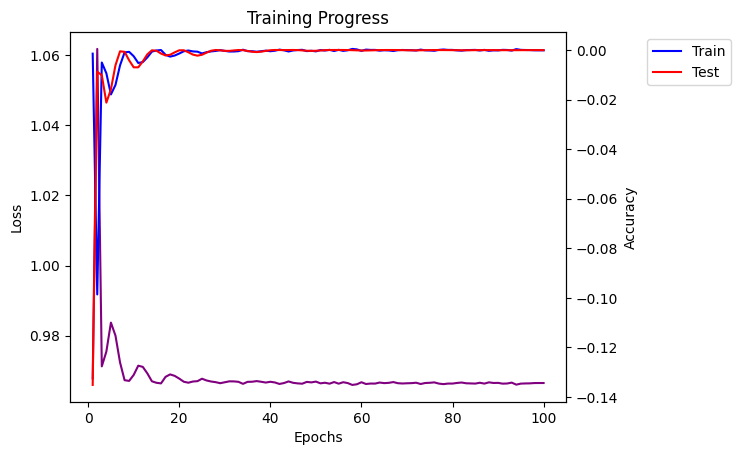

Train accuracy: -0.00013375282287597656
Test accuracy: -6.663799285888672e-05


In [ ]:
# @title Run learning and testing
gcn = model([32, 64, 128, 128, 128, 128], device=device, dropout=dropout_p)
optimizer = torch.optim.Adam(gcn.parameters(), lr=lr)

# prepare train dicts
train_x_dict = train_data.x_dict
train_edge_index_dict = train_data.edge_index_dict
train_edge_attr_dict = train_data.edge_attr_dict
train_edge_weight_dict = train_data.edge_weight_dict

# prepare test dicts
test_x_dict = test_data.x_dict
test_edge_index_dict = test_data.edge_index_dict
test_edge_attr_dict = test_data.edge_attr_dict
test_edge_weight_dict = test_data.edge_weight_dict

# prepare lists for values
epochs = []
train_acc = []
test_acc = []
loss_values = []

for epoch in range(num_epoch):
  epochs.append(epoch+1)
  print("\rEpoch: {}".format(epoch+1), end="", flush=True)

  #=============================================================================
  # Train
  #=============================================================================
  gcn.train()
  optimizer.zero_grad()

  # train
  pred = gcn(train_x_dict, train_edge_index_dict, train_edge_attr_dict, train_edge_weight_dict)

  # prepare validation data
  ground_truth = train_data['teamInMatch', 'result', 'teamInMatch'].result.to(device)
  ground_truth.requires_grad = True

  # calculate loss
  loss = crit(pred, ground_truth)
  if loss.isnan() or loss.isinf():
    print(pred)
    print(ground_truth)
    raise Exception("Loss has NaN or Inf value.")
  loss_values.append(loss.item())
  loss.backward()
  optimizer.step()

  # calculate accuracy
  acc.reset()
  acc.update(pred, ground_truth)
  train_acc.append(acc.compute().item())


  #=============================================================================
  # Test
  #=============================================================================
  gcn.eval()

  # test
  pred = gcn(test_x_dict, test_edge_index_dict, test_edge_attr_dict, test_edge_weight_dict)[-N:]
  ground_truth = train_data['teamInMatch', 'result', 'teamInMatch'].result.to(device)[-N:]
  acc.reset()
  acc.update(pred, ground_truth)
  test_acc.append(acc.compute().item())

#===============================================================================
# Plot result
#===============================================================================
print("\r", end="")
warnings.filterwarnings("ignore", category=UserWarning, message="No artists with labels found to put in legend")

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

ax1.plot(epochs, loss_values, label='Loss', color='purple')
ax2.plot(epochs, train_acc, label='Train', color='blue')
ax2.plot(epochs, test_acc, label='Test', color='red')

plt.title("Training Progress")
plt.legend(labels=['Train', 'Test', 'Loss'], loc="upper left", bbox_to_anchor=(1.15, 1.0))
plt.show()

print("Train accuracy:", train_acc[-1])
print("Test accuracy:", test_acc[-1])